# Introduction


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

import datetime
from datetime import date, timedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.dates import date2num, DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
import matplotlib.patches as mpatches

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

import seaborn as sns

import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

from scipy import stats
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

%matplotlib inline

# 2. Dow Jones Index Analysis


In [2]:
dow_jones_index_stock = yf.download("^DJI", start=datetime.datetime(1984, 1, 1), 
                                     end=datetime.datetime(2023, 1, 1))
dow_jones_index_stock

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1992-01-02,3152.100098,3172.629883,3139.310059,3172.399902,3172.399902,23550000
1992-01-03,3172.399902,3210.639893,3165.919922,3201.500000,3201.500000,23620000
1992-01-06,3201.500000,3213.330078,3191.860107,3200.100098,3200.100098,27280000
1992-01-07,3200.100098,3210.199951,3184.479980,3204.800049,3204.800049,25510000
1992-01-08,3204.800049,3229.199951,3185.820068,3203.899902,3203.899902,29040000
...,...,...,...,...,...,...
2022-12-23,32961.058594,33226.140625,32814.019531,33203.929688,33203.929688,221050000
2022-12-27,33224.230469,33387.718750,33069.578125,33241.558594,33241.558594,246010000
2022-12-28,33264.761719,33379.550781,32869.148438,32875.710938,32875.710938,252260000


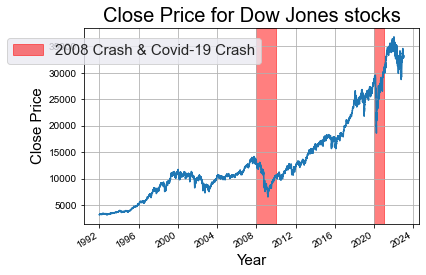

In [3]:
def dow_jones_stock_plot():
    dow_jones_index_stock['Close'].plot(grid = True)
    sns.set(rc={'figure.figsize':(20, 10)})
    plt.axvspan('2008','2010',color='red',alpha=.5)
    plt.axvspan('2020','2021',color='red',alpha=.5)
    labs = mpatches.Patch(color='red',alpha=.5, label="2008 Crash & Covid-19 Crash")
    plt.legend(handles=[labs], prop={"size":15},  bbox_to_anchor=(0.15, 0.95), loc='upper center', borderaxespad=0.)
    plt.title('Close Price for Dow Jones stocks', color = 'black', fontsize = 20)
    plt.xlabel('Year', color = 'black', fontsize = 15)
    plt.ylabel('Close Price', color = 'black', fontsize = 15)
    plt.show();

dow_jones_stock_plot()

## 5. Data transformation

We must convert the original closing price data into a format that effectively represents the aspect we are studying, which is the ranking of average monthly volatility (AMVR).

### 5.1 Percentage change

In [4]:
# To model returns we will use pct_change() to compute the percentage change from the previous row by default.
daily_returns = dow_jones_index_stock['Close'].pct_change()
# Drop the first value which becomes a 'NaN' as there is no price change from the day before.
daily_returns.dropna(inplace=True)
# Daily precentage change
daily_returns.head()

Date
1992-01-03    0.009173
1992-01-06   -0.000437
1992-01-07    0.001469
1992-01-08   -0.000281
1992-01-09    0.001748
Name: Close, dtype: float64

### 5.2 Resample returns

In [5]:
monthly_annual = daily_returns.resample('M').std()* np.sqrt(12)

monthly_annual.head()

Date
1992-01-31    0.026666
1992-02-29    0.023972
1992-03-31    0.017382
1992-04-30    0.029597
1992-05-31    0.020011
Freq: M, Name: Close, dtype: float64

### 5.3 Plot returns

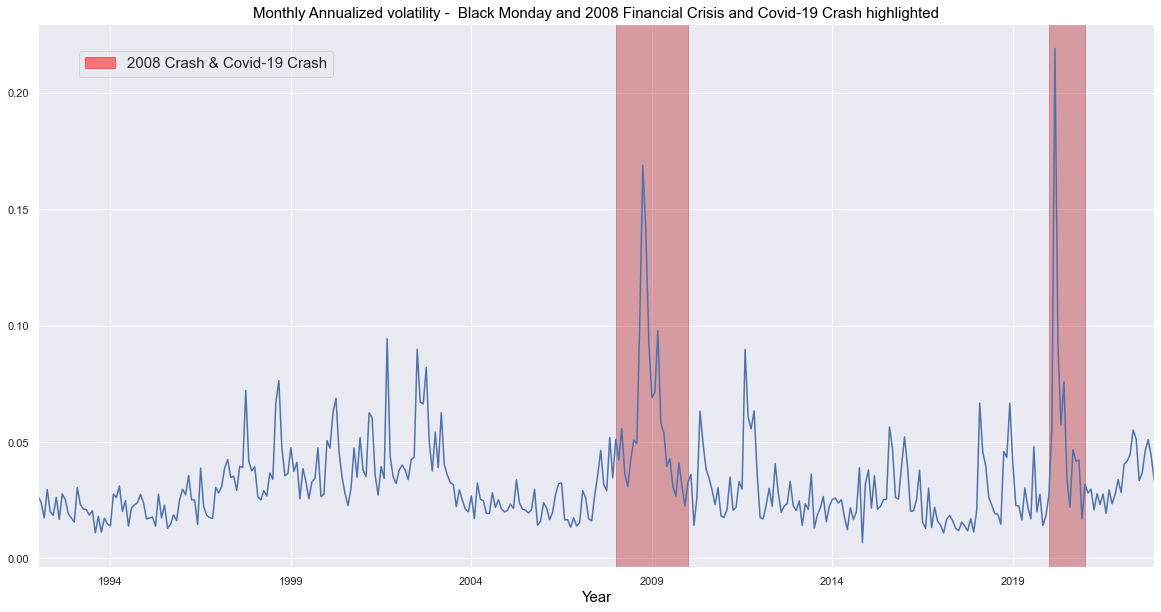

In [6]:
# We can see the major market events show up in the volatility

def dow_jones_index_stock_month():
    monthly_annual.plot(grid = True)
    sns.set(rc={'figure.figsize':(15, 5)})
    plt.axvspan('2008','2010',color='r',alpha=.5)
    plt.axvspan('2020','2021',color='r',alpha=.5)
    labs = mpatches.Patch(color='red',alpha=.5, label="2008 Crash & Covid-19 Crash")
    plt.legend(handles=[labs], prop={"size":15},  bbox_to_anchor=(0.15, 0.95), loc='upper center', borderaxespad=0.)
    plt.title('Monthly Annualized volatility -  Black Monday and 2008 Financial Crisis and Covid-19 Crash highlighted', color = 'black', fontsize = 15)
    plt.xlabel('Year', color = 'black', fontsize = 15)
    plt.show();

dow_jones_index_stock_month()

### 5.4 Calculate Annual Monthly Volatility Rankings (AMVR) metric
AMVR, or Average Monthly Volatility Ranking, is a derived measure used to analyze and understand the volatility trends within a dataset, particularly financial or economic time series data. To calculate AMVR values, we employ a systematic process using Python's Pandas library.

Initially, we group the data based on monthly intervals using the groupby() method. In this case, we specifically use the monthly_annual values and group them by the year attribute found in the datetime index of the monthly_annual data.

After this initial grouping, we apply the rank() method, which arranges the data in ascending order. This ranking is essential because it allows us to evaluate the relative volatility of each month within a given year.

To obtain the final AMVR values, we repeat this grouping and ranking process for each year and each month. By averaging the ranked values across all years for each specific month, we can determine the Average Monthly Volatility Ranking. This ranking provides valuable insights into the consistency and relative volatility of different months across the dataset, enabling more informed analysis and decision-making in the context of financial or economic data.

In [7]:
# Group volatility by year and create a ranking for each of the 12 months over all 37 years of data

# for each year rank each month based on volatility lowest=1 highest=12
ranked_month = monthly_annual.groupby(monthly_annual.index.year).rank()

# average the ranks over all years for each month
final_rank = ranked_month.groupby(ranked_month.index.month).mean()

final_rank.describe()

count    12.000000
mean      6.500000
std       0.717828
min       5.225806
25%       5.935484
50%       6.709677
75%       6.846774
max       7.580645
Name: Close, dtype: float64

In [8]:
# This gives our final Average Monthly Volatility Rankings. 
# the final average results over 37 years 

min_val = final_rank.idxmin()
max_val = final_rank.idxmax()
print(final_rank)
print(f'Month {min_val} is the least volatile')
print(f'Month {max_val} is the most volatile')

Date
1     6.645161
2     6.806452
3     7.580645
4     6.967742
5     6.774194
6     6.354839
7     5.838710
8     5.225806
9     6.806452
10    7.419355
11    5.967742
12    5.612903
Name: Close, dtype: float64
Month 8 is the least volatile
Month 3 is the most volatile


Numerically we can see that month 3 (March) is the most volatile and 8 (August) is the least volatile. 

### 5.5 Plot AMVR values

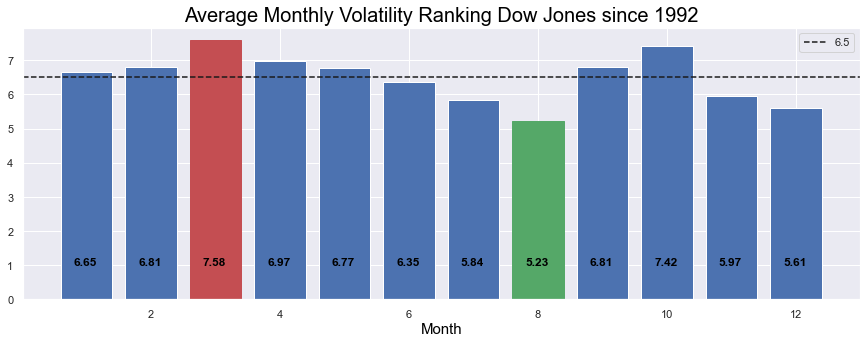

In [9]:
# Plot results for ranked Dow Jones volatility

b_plot = plt.bar(x=final_rank.index,height=final_rank)
b_plot[7].set_color('g')
b_plot[2].set_color('r')
for i,v in enumerate(round(final_rank,2)):
    plt.text(i+.8,1,str(v), color='black', fontweight='bold')
plt.axhline(final_rank.mean(),ls='--',color='k',label=round(final_rank.mean(),2))
plt.title('Average Monthly Volatility Ranking Dow Jones since 1992', color = 'black', fontsize = 20)
plt.xlabel('Month', color = 'black', fontsize = 15)
plt.legend()
plt.show()

## 6. Hypothesis Testing
In statistical analysis, our primary objective is to determine whether the observed effect in our dataset is genuine or could have occurred due to random chance. To rigorously assess this, we follow a systematic testing process, which involves the following key steps:

Selection of a Test Statistic: We begin by selecting an appropriate test statistic that quantifies the effect we are investigating. The choice of test statistic depends on the nature of the data and the hypothesis we want to test. It serves as a crucial indicator for measuring the significance of our findings.

Formulation of a Null Hypothesis (H0): The null hypothesis is a fundamental component of hypothesis testing. It represents the scenario where there is no real effect or difference in the data. It acts as a benchmark against which we compare our observed results. The null hypothesis often includes specific conditions or parameters that describe the absence of an effect.

Computation of a p-value: The p-value is a pivotal element in hypothesis testing. It is a probability metric that quantifies the likelihood of obtaining results as extreme or more extreme than what we observed, assuming that the null hypothesis is true. In essence, it tells us the probability of the observed effect occurring by random chance. A smaller p-value suggests stronger evidence against the null hypothesis.

By following these steps, we engage in a systematic and data-driven process to determine the statistical significance of our findings. The p-value serves as a crucial guide, helping us make informed decisions about whether to accept or reject the null hypothesis, which, in turn, informs us about the reality of the observed effect in our data.

### 6.1 Choose an appropriate ‘test statistic’
The concept we are exploring revolves around a straightforward numerical measure, which quantifies the observed effect in our data. Specifically, we are interested in the absolute deviation in Average Monthly Volatility Ranking (AMVR) from its mean value.

In essence, our primary inquiry is whether the most extraordinary data point, characterized by the most significant absolute deviation from the mean AMVR, could be a mere product of chance variation. This notion helps us define the most extreme value within our dataset as the instance with the greatest absolute AMVR deviation from the mean.

This exploration revolves around assessing the extremeness of our data points in relation to their deviation from the typical or average behavior. The aim is to ascertain whether such an extreme value is a random occurrence or if it carries substantial significance, thereby contributing to our understanding of the underlying phenomena. In the realm of statistical analysis, the identification of these extreme values is crucial in discerning patterns, trends, or anomalies in our data.

In [10]:
# Take abs value move from the mean

fin = abs(final_rank - final_rank.mean())
print(fin.sort_values())
Mar_value = fin[2]
Aug_value = fin[7]
print('Extreme Mar value:', Mar_value)
print('Extreme Aug value:', Aug_value)

Date
1     0.145161
6     0.145161
5     0.274194
2     0.306452
9     0.306452
4     0.467742
11    0.532258
7     0.661290
12    0.887097
10    0.919355
3     1.080645
8     1.274194
Name: Close, dtype: float64
Extreme Mar value: 0.306451612903226
Extreme Aug value: 0.661290322580645


In our dataset, the highest values is the Aug value at 1.27 and the Mar vaue at 1.08. The Aug vlaue has the most significant absolute deviation from the mean as well as the lowest volatility. 

### 6.2. Construct a Null Hypothesis

The fundamental premise of our analysis is encapsulated within the concept of the null hypothesis. In this context, the null hypothesis postulates that the data contains no inherent seasonality, and any observed effects are mere products of chance. Alternatively, it suggests that the specific month plays no significant role in determining the Average Monthly Volatility Ranking (AMVR).

To rigorously assess this null hypothesis, we must create an idealized representation of a dataset devoid of seasonality. This hypothetical dataset serves as a crucial reference point, ensuring that any exceptional observations, such as the extreme AMVR value in October, are equally probable for all months. Essentially, we strive to eliminate any inherent patterns associated with seasonal variations.

The method employed to establish this simulated dataset involves the repeated shuffling of the 'daily' return data. This shuffling operation effectively disrupts the 'month' labels, rendering them arbitrary. The underlying assumption here is that if the null hypothesis holds true, the labels for each month (e.g., January, February, etc.) lose their significance and become interchangeable.

The simulated dataset that arises from this process is known as the 'sampling distribution of the test statistic under the null hypothesis.' It provides a reference point against which we can compare our actual data. By contrasting our observed effect with the distribution of effects generated under the null hypothesis, we gain valuable insights into the validity of our initial hypothesis regarding seasonality and its impact on AMVR. This rigorous examination allows us to draw meaningful conclusions about the role of time-based patterns in our data.

In [11]:
# Dataset has 7808 values

daily_returns

Date
1992-01-03    0.009173
1992-01-06   -0.000437
1992-01-07    0.001469
1992-01-08   -0.000281
1992-01-09    0.001748
                ...   
2022-12-23    0.005342
2022-12-27    0.001133
2022-12-28   -0.011006
2022-12-29    0.010497
2022-12-30   -0.002214
Name: Close, Length: 7808, dtype: float64

### Simulation through resampling

In [12]:
# Simulate data to create a null dataset

new_df_sim = pd.DataFrame()
highest_only = []

count=0
n=1000
for i in range(n):
    # randomly sample from daily returns same size as dataset, drop timestamp 
    daily_returns_shuffle = daily_returns.sample(7808).reset_index(drop=True)
    #add new timestamp to shuffled data
    daily_returns_shuffle.index = (pd.bdate_range(start='1992-1-4',periods=7808))
    
    #then follow same data wrangling as before
    monthly_annual = daily_returns_shuffle.resample('M').std()* np.sqrt(12)
    
    ranked = monthly_annual.groupby(monthly_annual.index.year).rank()
    sim_final = ranked.groupby(ranked.index.month).mean()
    #add each of 1000 sims into df
    new_df_sim = pd.concat([new_df_sim,sim_final],axis=1)
    
    #also record just highest AMVR for each year 
    maxi_month = max(sim_final)
    highest_only.append(maxi_month)
    

    
#calculate absolute deviation in AMVR from the mean
all_months = new_df_sim.values.flatten()
mu_all_months = all_months.mean()
abs_all_months = abs(all_months-mu_all_months)    

#calculate absolute deviation in highest only AMVR from the mean
mu_highest = np.mean(highest_only)
abs_highest = [abs(x - mu_all_months) for x in highest_only]

### 6.3 Compute a p-value
The concept of the p-value plays a pivotal role in hypothesis testing, shedding light on the likelihood of encountering the observed effect within a dataset that adheres to the null hypothesis. Essentially, it quantifies the probability of the observed effect occurring purely by chance.

In the context of our analysis, we are now poised to conduct a hypothesis test. Specifically, we aim to determine the probability of witnessing an outcome as remarkable as the October result, given the underlying assumption that the null hypothesis holds true—namely, that there is no seasonality within the data.

This hypothesis test is instrumental in evaluating the credibility of our initial proposition. By calculating the p-value, we can assess whether the observed effect, exemplified by the extreme October result, aligns with what we would expect to see under the null hypothesis. The p-value provides us with a clear statistical indicator of whether seasonality significantly impacts the Average Monthly Volatility Ranking (AMVR) or whether the October result could indeed be attributed to random chance. It's a critical component in the process of making informed decisions about the data and the presence of seasonal patterns.

### What is the probability that March would appear this extreme by chance?

To compute the p-value we count how many values in our dataset using all 12000 AMVR deviations (12 months x 1000 trials) are greater than the observed March value.

In [13]:
# Count number of months in simulated data where AMVR deviation is > Oct
# comparing against all months
# We are using Oct, as it has highest absolute deviation from the mean
count=0
for i in abs_all_months:
    if i> Mar_value:
        count+=1
ans = count/len(abs_all_months)        
print('p-value:', ans )

p-value: 0.6165833333333334


### What is the probability any month would appear this extreme by chance?

To reduce the effect of multiple comparison bias, instead of comparing our result to the distribution made with all 12000 AMVR deviations, which assumes we are testing for a significant result against all 12 months, we will only consider the highest value from each of the absolute AMVR 1000 trials.  

In [14]:
# Count number of months in simulated data where AMVR deviation is > Oct
# but just considering highest AMVR for each of 1000 trials
count=0
for i in abs_highest:
    if i> Mar_value:
        count+=1
ans = count/len(abs_highest)        
print('p-value:', ans )

p-value: 1.0


## Plot the two distributions

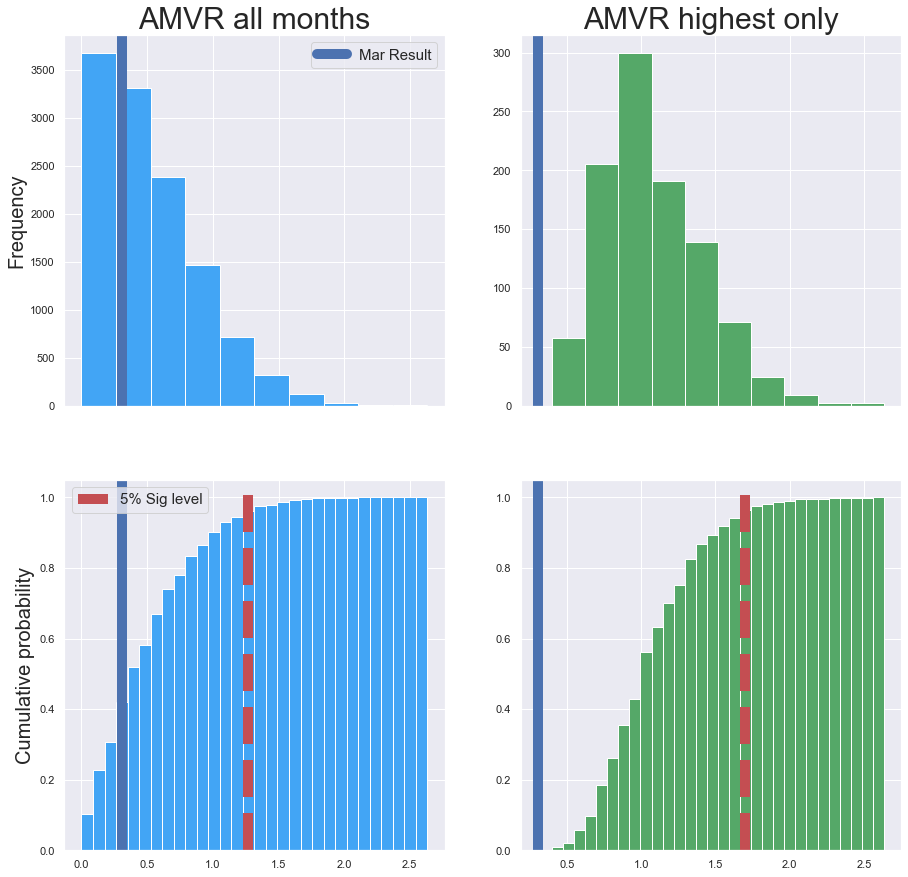

In [15]:
# Calculate 5% significance
abs_all_months_95 = np.quantile(abs_all_months,.95)
abs_highest_95 = np.quantile(abs_highest,.95)

# Plot AMVR all months in left column and AMVR highest only in right column
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex='col',figsize=(15,15))


#plot 1 AMVR all months
ax1.hist(abs_all_months,histtype='bar',color='#42a5f5')
ax1.set_title('AMVR all months',fontsize=30)
ax1.set_ylabel('Frequency',fontsize=20)
n,bins,patches = ax3.hist(abs_all_months,density=1,histtype='bar',cumulative=True,bins=30,color='#42a5f5')
ax3.set_ylabel('Cumulative probability',fontsize=20)
ax1.axvline(Mar_value,color='b',label='Mar Result',lw=10)
ax3.axvline(Mar_value,color='b',lw=10)
ax3.axvline(abs_all_months_95,color='r',ls='--',label='5% Sig level',lw=10)


#plot 2 AMVR highest only
ax2.hist(abs_highest,histtype='bar',color='g')
ax2.set_title('AMVR highest only',fontsize=30)
ax2.axvline(Mar_value,color='b',lw=10)
n,bins,patches = ax4.hist(abs_highest,density=1,histtype='bar',cumulative=True,bins=30,color='g')
ax4.axvline(Mar_value,color='b',lw=10)
ax4.axvline(abs_highest_95,color='r',ls='--',lw=10)

ax1.legend(fontsize=15)
ax3.legend(fontsize=15);